In [24]:
import pickle
import matplotlib.pyplot as plt
from functools import lru_cache
import os
import astropy.table

In [141]:
@lru_cache(maxsize=512)
def parse_results(pg, detector, snr):
    """
    What I want to know is the magnitude of the fakes that I found
    what was possible to find and not possible to find
    """
    search_path = f"../search/{pg}/detector_{detector}/snr_{snr}"
    try:
        with open(f"{search_path}/recover.pkl", "rb") as fd:
            recovery = pickle.load(fd)
        with open(f"{os.path.dirname(search_path)}/fakes.pkl", "rb") as fd:
            fakes = pickle.load(fd)
    except Exception as e:
        print(search_path)
        return []
    
    did_find = recovery['did_find']
    possible_to_find = recovery['possible_to_find']
    results = []
    for fake in fakes.group_by("ORBITID").groups:
        mag = fake[0]['MAG']
        orbit = fake[0]['ORBITID']
        
        result = dict(
            orbit=orbit,
            mag=mag,
            possible=possible_to_find[orbit][0],
            found=possible_to_find[orbit][0] and len(did_find[orbit]) > 0,
        )
        results.append(result)
    
    return results

In [143]:
def gather_results(snr, pgs):
    results = []
    for pg in pgs:
        for detector in map(int, "1 3 4 5 6 7 8 9 10 16 24".split()):
            results.extend(parse_results(pg, detector, snr))
    results = astropy.table.Table(results)
    return results

../search/DEEP/20190403/A0c/detector_3/snr_5
../search/DEEP/20190403/A0c/detector_3/snr_4
../search/DEEP/20190403/A0c/detector_3/snr_3


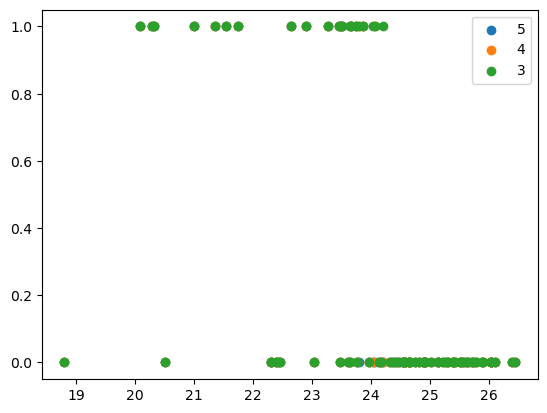

In [144]:
pgs = "DEEP/20190403/A0c DEEP/20210504/A0f DEEP/20210509/A0g DEEP/20210513/A0e DEEP/20210515/A0h DEEP/20220525/A0f DEEP/20220825/B1e DEEP/20220826/B1l DEEP/20220827/B1b DEEP/20220827/B1i".split(" ")
fig = plt.figure()
for snr in [5, 4, 3]:
    results = gather_results(snr, pgs[0:1])
    plt.scatter(results['mag'], results['found'], label=snr)
    plt.legend()
    
plt.show()

In [156]:
def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog['mag'] >= lower) & (catalog['mag'] < upper)]
        if len(a) > 0:
            num_recovered = a['found'].sum()
            num_possible = a['possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, errors

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as np

def p(m, c, k, m_50):
    return c / (1 + np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return np.log(c) - np.log(1 + np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return np.sum(log_p(recovered_mag, c, k, m_50)) + np.sum(np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return (
        np.sum(np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        np.sum(np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)

In [46]:
results

orbit,mag,possible,found
int64,float64,bool,bool
10451789,23.754786918061548,True,True
10564514,26.04233609781812,False,False
11858007,25.21849646313006,False,False
12436625,25.62081342652167,False,False
13008433,24.037339095089585,True,True
13396487,25.39680414154894,False,False
13711875,20.29613874022196,True,True
13820098,24.54095899600907,False,False
13842309,25.57146478960704,False,False


/tmp/ipykernel_71591/3955571040.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fraction_recovered.append(num_recovered/num_possible)
/tmp/ipykernel_71591/3955571040.py:23: RuntimeWarning: divide by zero encountered in power
  errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)


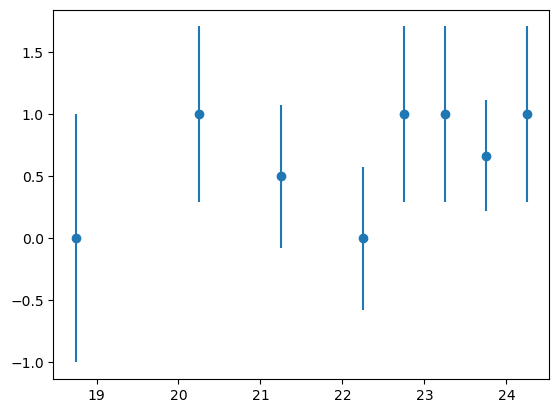

In [45]:
x, y, yerr = bin_detection(results, 18, 26)
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.show()

In [145]:
results[results['found']]['mag'].value

array([23.79930465, 21.75589796, 24.20120428, 20.32811758, 20.08346034,
       23.75478692, 24.0373391 , 20.29613874, 22.65379997, 24.06428573,
       21.36560918, 23.46846412, 23.65398756, 21.54848274, 22.89645298,
       23.86165253, 20.99915808, 23.50793319, 23.50104714, 23.26728729,
       23.67019271])

In [157]:

def do_fit(results):
    recovered_mag = results[results['found']]['mag'].value
    missed_mag = results[~results['found']]['mag'].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = np.sqrt(np.diag(np.linalg.inv(hess)))
        else:
            fit_std = np.array([np.nan, np.nan, np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d


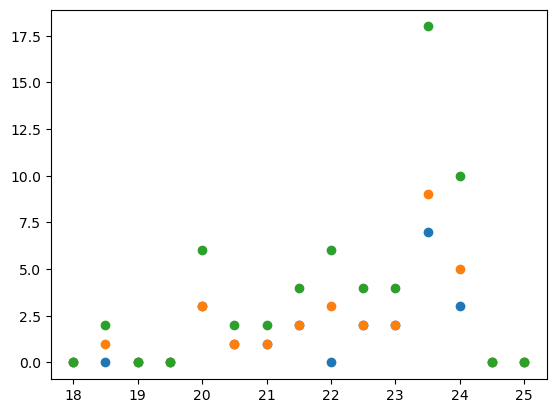

In [147]:
bins = np.arange(int(results['mag'].min()), int(results['mag'].max() + 0.5), 0.5)
found_counts, _ = np.histogram(results[results['possible'] & results['found']]['mag'], bins=bins)
possible_counts, _ = np.histogram(results[results['possible']]['mag'], bins=bins)
missed_counts, _ = np.histogram(results[results['possible'] & ~results['found']]['mag'], bins=bins)
plt.scatter(bins[:-1], found_counts)
plt.scatter(bins[:-1], found_counts + missed_counts)
plt.scatter(bins[:-1], found_counts + missed_counts + possible_counts)
plt.show()

In [64]:
bin_detection(results[results['found']], 19, 26)

([20.25, 21.25, 22.75, 23.25, 23.75, 24.25],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.7071067811865476,
  0.7071067811865476,
  0.7071067811865476,
  0.7071067811865476,
  0.5,
  0.7071067811865476])

In [65]:
bin_detection(results[~results['found'] & results['possible']], 19, 26)


([21.25, 22.25, 23.75], [0.0, 0.0, 0.0], [1.0, 0.5773502691896257, 1.0])

In [66]:
bin_detection(results[~results['possible']], 19, 26)


/tmp/ipykernel_71591/3955571040.py:21: RuntimeWarning: invalid value encountered in scalar divide
  fraction_recovered.append(num_recovered/num_possible)
/tmp/ipykernel_71591/3955571040.py:23: RuntimeWarning: divide by zero encountered in power
  errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)


([21.25, 22.75, 23.25, 23.75, 24.25, 24.75, 25.25, 25.75, 26.25],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [inf, inf, inf, inf, inf, inf, inf, inf, inf])

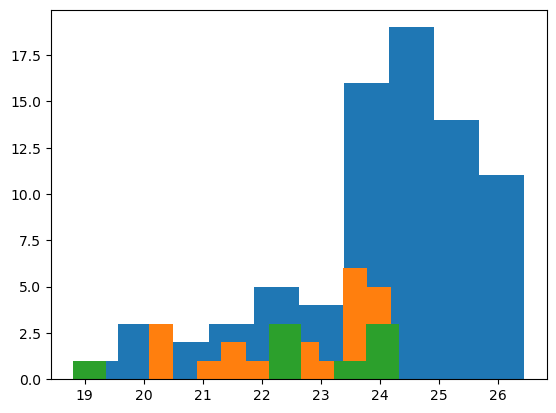

In [148]:
plt.hist(results['mag'])
plt.hist(results[results['found']]['mag'])
plt.hist(results[~results['found'] & results['possible']]['mag'])
plt.show()

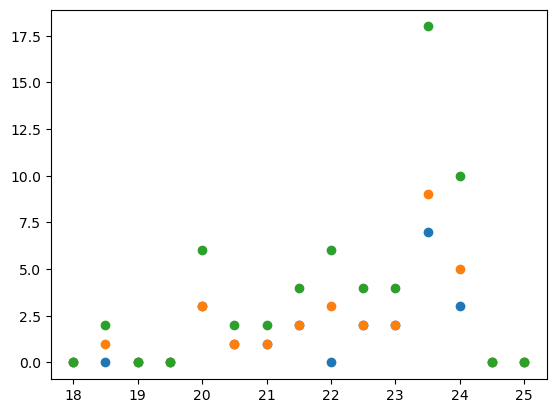

In [149]:
bins = np.arange(int(results['mag'].min()), int(results['mag'].max() + 0.5), 0.5)
found_counts, _ = np.histogram(results[results['possible'] & results['found']]['mag'], bins=bins)
possible_counts, _ = np.histogram(results[results['possible']]['mag'], bins=bins)
missed_counts, _ = np.histogram(results[results['possible'] & ~results['found']]['mag'], bins=bins)

plt.scatter(bins[:-1], found_counts)
plt.scatter(bins[:-1], found_counts + missed_counts)
plt.scatter(bins[:-1], found_counts + missed_counts + possible_counts)
plt.show()

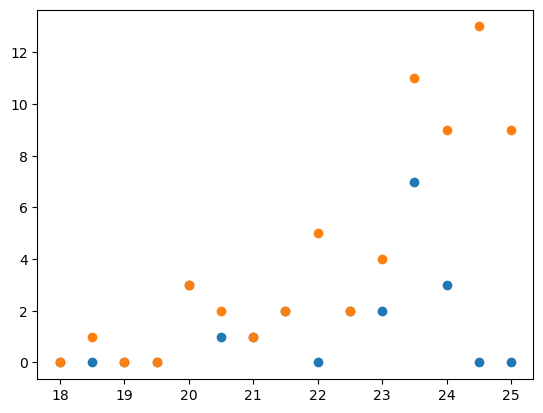

In [150]:
bins = np.arange(int(results['mag'].min()), int(results['mag'].max() + 0.5), 0.5)
found_counts, _ = np.histogram(results[results['possible'] & results['found']]['mag'], bins=bins)
missed_counts, _ = np.histogram(results[~results['found']]['mag'], bins=bins)

plt.scatter(bins[:-1], found_counts)
plt.scatter(bins[:-1], found_counts + missed_counts)
plt.show()


In [155]:
fit_results

{5: {'fit': {'c': 0.5666666689989807,
   'k': 1127.2542770552295,
   'm_50': 23.89198547277303,
   'sigma_c': nan,
   'sigma_k': nan,
   'sigma_m_50': nan},
  'bins': array([18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ,
         23.5, 24. , 24.5, 25. , 25.5]),
  'fraction': array([nan,  0., nan, nan, inf, inf, inf, inf,  0., inf, inf, inf, nan,
         nan, nan])},
 4: {'fit': {'c': 0.5757575759094112,
   'k': 1103.8791421396957,
   'm_50': 24.091917324830288,
   'sigma_c': nan,
   'sigma_k': nan,
   'sigma_m_50': nan},
  'bins': array([18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ,
         23.5, 24. , 24.5, 25. , 25.5]),
  'fraction': array([nan,  0., nan, nan, inf, inf, inf, inf,  0., inf, inf,  7.,  1.,
         nan, nan])},
 3: {'fit': {'c': 0.594895935480574,
   'k': 24.24517222680109,
   'm_50': 24.222061714789838,
   'sigma_c': 0.08965863273751609,
   'sigma_k': 32.636465604860796,
   'sigma_m_50': 0.11774979491535785},
  'bins': array([1

In [161]:
pgs="DEEP/20190403/A0c DEEP/20210504/A0f DEEP/20210509/A0g DEEP/20210513/A0e DEEP/20210515/A0h DEEP/20220525/A0f DEEP/20220825/B1e DEEP/20220826/B1l DEEP/20220827/B1b DEEP/20220827/B1i".split(" ")

fit_results = {}
for snr in [5, 4, 3]:
    results = gather_results(snr, pgs[0:1])
    fit = do_fit(results)
    bins = np.arange(int(results['mag'].min()), int(results['mag'].max() + 0.5), 0.5)
    found_counts, _ = np.histogram(results[results['possible'] & results['found']]['mag'], bins=bins)
    possible_counts, _ = np.histogram(results[results['possible']]['mag'], bins=bins)
    missed_counts, _ = np.histogram(results[results['possible'] & ~results['found']]['mag'], bins=bins)
    
    fit_results[snr] = dict(fit=fit, bins=bins, fraction=found_counts/missed_counts)

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, 

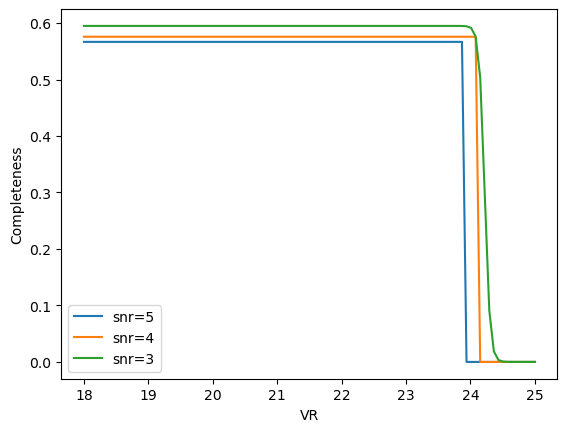

In [173]:

for snr in [5, 4, 3]:
    fit_result = fit_results[snr]
    fit = fit_result['fit']
    bins = fit_result['bins']
    fraction = fit_result['fraction']
#     plt.scatter(bins[:-1], fraction)
    _x = np.linspace(bins[:-1].min(), bins[:-1].max(), 100)
    plt.plot(_x, p(_x, fit['c'], fit['k'], fit['m_50']), label=f"snr={snr}")

plt.legend()
plt.xlabel("VR")
plt.ylabel("Completeness")
plt.show()

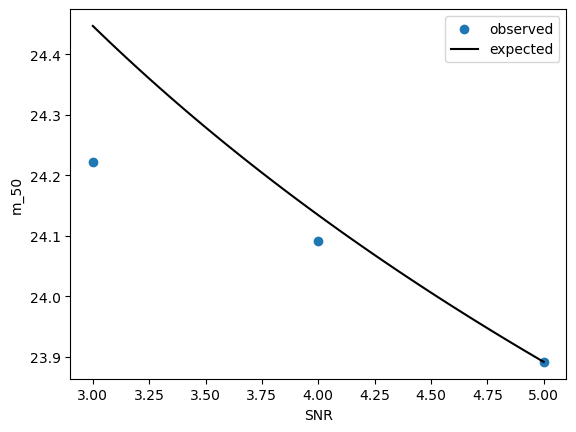

In [177]:
snrs = [5, 4, 3]
half_mag = [fit_results[snr]['fit']['m_50'] for snr in snrs]
_snrs = np.linspace(min(snrs), max(snrs), 100)
expected = -5/2*np.log10(_snrs/max(snrs)) + half_mag[0]
plt.scatter(snrs, half_mag, label="observed")
plt.plot(_snrs, expected, label="expected", c='k')
plt.xlabel("SNR")
plt.ylabel("m_50")
plt.legend()
plt.show()

In [170]:
recovery['result']['detections'].keys()

dict_keys([10564514, 13711875, 13820098, 13842309, 13396487, 14967241, 10451789, 12436625, 14795314, 13008433, 11858007, 14674042])

In [165]:
results[results['found']]

orbit,mag,possible,found
int64,float64,bool,bool
13776855,23.799304654954085,True,True
14621325,21.755897962503614,True,True
14813564,24.2012042804041,True,True
14699459,20.32811758025379,True,True
14969959,20.08346033742506,True,True
10451789,23.754786918061548,True,True
13008433,24.037339095089585,True,True
13711875,20.29613874022196,True,True
14795314,22.653799970293626,True,True


In [120]:
expected

[23.76148061365027, 24.00375564617041, 24.31610248769116]